<b>
<p>
<center>
<font size="9">
Weather Image Recognition
</font>
</center>
</p>

<p>
<center>
<font size="5">
using
</font>
</center>
</p>

<p>
<center>
<font size="6">
 Convolutional Neural Networks(CNNs)
</font>
</center>
</p>
    
<p>
<center>
<font size="4">
Machine Learning I
</font>
</center>
</p>

<p>
<center>
<font size="3">
Data Science, Columbian College of Arts & Sciences, George Washington University
</font>
</center>
</p>

<p>
<center>
<font size="5">
Chaya Chandana Doddaiggaluru Appajigowda(G35408608)
</font>
</center>
</p>
</b>

# Overview

- This notebook includes code for Convolutional Neural Networks used to classify weather images.
- Here we will work on the Kaggle Dataset [weather_image_Recognition](https://www.kaggle.com/datasets/jehanbhathena/weather-dataset).
- The goal of this project:


# Notebook Configuration

## Google drive

In [1]:
from google.colab import drive
import sys

# Mount Google Drive
drive.mount('/content/drive')

# Get the absolute path of the current folder
abspath_curr = '/content/drive/My Drive/Colab Notebooks/ML_1/Final Project/'

# Get the absolute path of the deep utilities folder
abspath_util_deep = '/content/drive/My Drive/Colab Notebooks/ML_1/code/utilities/p3_deep_learning/'

Mounted at /content/drive


## Warning

In [2]:

import warnings

# Ignore warnings
warnings.filterwarnings('ignore')

## Matplotlib

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

# Set matplotlib sizes
plt.rc('font', size=20)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('legend', fontsize=20)
plt.rc('figure', titlesize=20)

## TensorFlow

In [4]:
# The magic below allows us to use tensorflow version 2.x
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras

# Print TensorFlow version to verify
print(tf.__version__)


Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
2.17.1


## Random seed

In [5]:

# The random seed
random_seed = 42

# Set random seed in tensorflow
tf.random.set_seed(random_seed)

# Set random seed in numpy
import numpy as np
np.random.seed(random_seed)

# Data Preprocessing

In [6]:
# Change working directory to the absolute path of the deep utilities folder
%cd $abspath_util_deep

# Import the deep utitilities
%run pmlm_utilities_deep.ipynb

/content/drive/My Drive/Colab Notebooks/ML_1/code/utilities/p3_deep_learning


## Loading the data

In this project, we will work on the [weather_image_recognition](https://www.kaggle.com/datasets/jehanbhathena/weather-dataset/data) dataset.

### Creating the directory for the data

In [7]:
import os

# Make directory
directory = os.path.dirname(abspath_curr + '/dataset/')
if not os.path.exists(directory):
    os.makedirs(directory)

### Downloading the data to the directory

In [8]:

# Load the dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=abspath_curr + '/dataset/',
    image_size=(256, 256),  # Resize images to 256x256
    batch_size=None,
    label_mode='int',  # Labels are returned as integers
    shuffle=True  # Shuffle the dataset before splitting
)
print("\nThe length of the dataset is ", len(dataset))

Found 6862 files belonging to 11 classes.

The length of the dataset is  6862


## Getting the name of the target

In [9]:
target = 'label'

## Getting the info

In [10]:
# Display class names

classes = dataset.class_names

print(classes)


['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']


In [11]:
# Get the number of classes
n_classes = len(classes)

# Print the number of classes
len(classes)


11

## Getting the training, validation and test data

In [12]:

# Get the total number of images
total_size = len(dataset)

print(total_size)

6862


In [13]:
# Calculate the sizes for Train (70%), Validation (15%), and Test (15%)
train_size = int(0.70 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size  # The remaining 15%

# Split the dataset using random_split
data_train = dataset.take(train_size)
data_rest = dataset.skip(train_size)
data_valid = data_rest.take(val_size)
data_test = data_rest.skip(val_size)



In [14]:
# Print the sizes of each split
print(f"Total images: {total_size}")
print(f"Train size: {len(data_train)}")
print(f"Validation size: {len(data_valid)}")
print(f"Test size: {len(data_test)}")

Total images: 6862
Train size: 4803
Validation size: 1029
Test size: 1030


## Resizing the data for pretrained model

In [15]:
# Set the default input size for the pretrained model
global input_size
input_size = [256, 256]

In [16]:
def resize(image, label):
    image = tf.image.resize(image, input_size)  # Resize image to input size
    return image, label

# Resize the training data
data_train = data_train.map(resize)

# Resize the validation data
data_valid = data_valid.map(resize)

# Resize the test data
data_test = data_test.map(resize)

## Preprocessing the data using pretrained model

In [17]:
# Set the preprocess_input of the pretrained model

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input



In [18]:
# Define the preprocessing function
def preprocess_pretrain(image, label):

    # Resize the image to 256x256
    image = tf.image.resize(image, (256, 256))

    # Normalize the image
    image = keras.applications.efficientnet.preprocess_input(image)

    return image, label


# Preprocess the training data using pretrained model

data_train = data_train.map(preprocess_pretrain)

# Preprocess the validation data using pretrained model
data_valid = data_valid.map(preprocess_pretrain)

# Preprocess the test data using pretrained model
data_test = data_test.map(preprocess_pretrain)

## Shuffling, batching and prefetching the data

In [19]:
# Shuffling the training data
data_train = data_train.shuffle(buffer_size=1000, seed=random_seed)

# Set the batch size
batch_size = 32

# Batch and prefetch the training data
data_train = data_train.batch(batch_size).prefetch(1)

# Batch and prefetch the validation data
data_valid = data_valid.batch(batch_size).prefetch(1)

# Batch and prefetch the test data
data_test = data_test.batch(batch_size).prefetch(1)

# Training

## Creating the directory for the model

In [20]:
# Make directory
directory = os.path.dirname(abspath_curr + '/MobileNetV2/result/model/')
if not os.path.exists(directory):
    os.makedirs(directory)

## Building the architecture of the model

In [21]:

# Load the pretrained MobileNetV2 model layers
pretrained_model = MobileNetV2(include_top=False, weights='imagenet')

# Add a GlobalAveragePooling2D layer
average_pooling = keras.layers.GlobalAveragePooling2D()(pretrained_model.output)

# Add Dropout layer to prevent overfitting
dropout = keras.layers.Dropout(0.5)(average_pooling)

# Add the Dense output layer with softmax activation
output = keras.layers.Dense(n_classes, activation='softmax')(dropout)

# Create the final model
model = keras.Model(inputs=pretrained_model.input, outputs=output)

# Print the model summary
model.summary()






9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None, None, 3)  │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, None, None, 32) │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, None, None, 32) │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, None, None, 32) │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, None, None, 32) │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, None, None, 32) │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, None, None, 32) │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, None, None, 16) │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, None, None, 16) │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, None, None, 96) │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, None, None, 96) │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, None, None, 96) │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, None, None, 96) │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, None, None, 96) │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,272,075 (8.67 MB)

 Trainable params: 2,237,963 (8.54 MB)

 Non-trainable params: 34,112 (133.25 KB)

## Freezing the pretrained layers

In [22]:
# For each layer in the pretrained model
for layer in pretrained_model.layers:
    # Freeze the layer
    layer.trainable = False

## Setting Callbacks

In [23]:
# ModelCheckpoint callback
model_checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath=abspath_curr + '/MobileNetV2/result/model/model.weights.h5',
                                                      save_best_only=True,
                                                      save_weights_only=True)

# EarlyStopping callback
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,
                                                  restore_best_weights=True)

# ReduceLROnPlateau callback
reduce_lr_on_plateau_cb = keras.callbacks.ReduceLROnPlateau(factor=0.1,
                                                            patience=1)

## Compiling the model
I used the default learning rate of Adam optimizer,but the accuracy was low. So I changed it to 0.001.

In [24]:
#Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## Training the model

In [25]:
# Train, evaluate and save the best model
history = model.fit(data_train,
                    epochs=20,
                    validation_data=data_valid,
                    callbacks=[model_checkpoint_cb,
                               early_stopping_cb,
                               reduce_lr_on_plateau_cb])

Epoch 1/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 173s 945ms/step - accuracy: 0.2303 - loss: 2.4369 - val_accuracy: 0.5452 - val_loss: 1.3237 - learning_rate: 0.0010
Epoch 2/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 45s 287ms/step - accuracy: 0.4770 - loss: 1.5321 - val_accuracy: 0.6122 - val_loss: 1.1821 - learning_rate: 0.0010
Epoch 3/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 33s 205ms/step - accuracy: 0.5383 - loss: 1.3237 - val_accuracy: 0.6142 - val_loss: 1.1347 - learning_rate: 0.0010
Epoch 4/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 28s 174ms/step - accuracy: 0.5735 - loss: 1.2310 - val_accuracy: 0.6278 - val_loss: 1.0772 - learning_rate: 0.0010
Epoch 5/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 27s 163ms/step - accuracy: 0.6019 - loss: 1.1580 - val_accuracy: 0.6433 - val_loss: 1.0411 - learning_rate: 0.0010
Epoch 6/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 26s 162ms/step - accuracy: 0.6057 - loss: 1.1669 - val_accuracy: 0.6618 - val_loss: 1.0118 - learning_rate: 0.0010
Epoch 7/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 25s 153ms/step - accuracy: 0.

## Plotting the learning curve

### Creating the directory for the figure

In [26]:
# Make directory
directory = os.path.dirname(abspath_curr + '/MobileNetV2/result/figure/')
if not os.path.exists(directory):
    os.makedirs(directory)

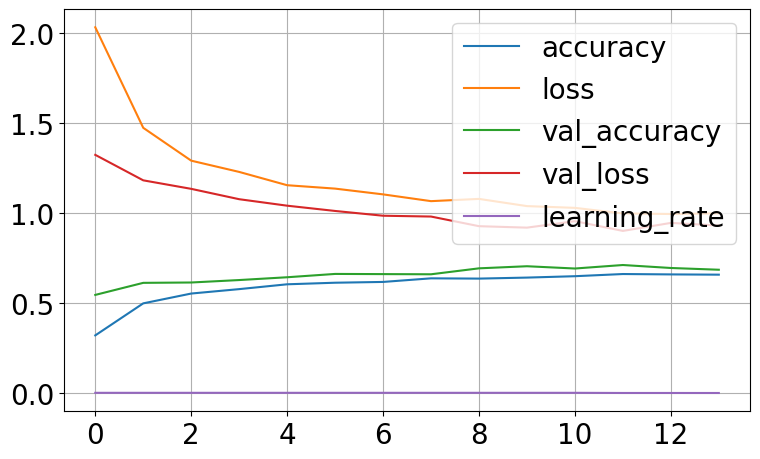

In [27]:
import pandas as pd

# Create a figure
pd.DataFrame(history.history).plot(figsize=(8, 5))

# Set grid
plt.grid(True)

# Save and show the figure
plt.tight_layout()
plt.savefig(abspath_curr + '/MobileNetV2/result/figure/learning_curve_before_unfreezing.pdf')
plt.show()

## Unfreezing the pretrained layers

In [28]:
# For each layer in the pretrained model
for layer in pretrained_model.layers:
    # Unfreeze the layer
    layer.trainable = True

## Compiling the model
Here we use a lower learning rate (by a factor of 10) of Adam optimizer, so that it is less likely to compromise the pretrained weights.

I adjusted it from 0.001 to 0.0001 because of the low test accuracy.

In [29]:
# Compile the model

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


## Training the model

In [30]:
# Train, evaluate and save the best model
history = model.fit(data_train,
                    epochs=15,
                    validation_data=data_valid,
                    callbacks=[model_checkpoint_cb,
                               early_stopping_cb,
                               reduce_lr_on_plateau_cb])

Epoch 1/15
151/151 ━━━━━━━━━━━━━━━━━━━━ 90s 295ms/step - accuracy: 0.5315 - loss: 2.1940 - val_accuracy: 0.3547 - val_loss: 6.7007 - learning_rate: 1.0000e-04
Epoch 2/15
151/151 ━━━━━━━━━━━━━━━━━━━━ 23s 139ms/step - accuracy: 0.8568 - loss: 0.4194 - val_accuracy: 0.4363 - val_loss: 4.3935 - learning_rate: 1.0000e-04


## Plotting the learning curve

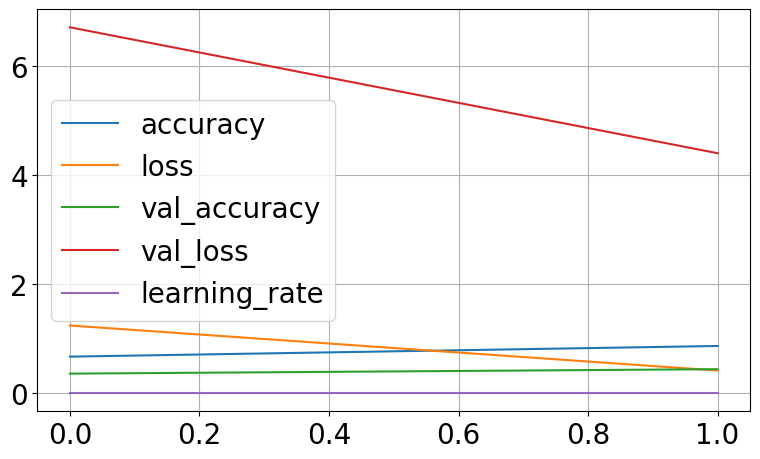

In [31]:
# Create a figure
pd.DataFrame(history.history).plot(figsize=(8, 5))

# Set grid
plt.grid(True)

# Save and show the figure
plt.tight_layout()
plt.savefig(abspath_curr + '/MobileNetV2/result/figure/learning_curve_after_unfreezing.pdf')
plt.show()

# Testing

## Loading the saved model

In [32]:
# Load the saved model
model.load_weights(filepath=abspath_curr + '/MobileNetV2/result/model/model.weights.h5')

## Evaluating the model

In [33]:
loss, accuracy = model.evaluate(data_test)

33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 382ms/step - accuracy: 0.6953 - loss: 0.9386
